In [66]:
import pandas as pd
df = pd.read_stata('sipp1991.dta')

print(df.shape)
df.sample(10)

(9915, 14)


,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
2731,294.0,-19706.0,-19706.0,48,32349.0,4,11,0,1,1,0,0,0,0
2242,5982.0,-2308.0,49692.0,40,29700.0,4,16,1,1,1,0,0,0,1
4220,27709.0,27209.0,143209.0,44,34794.0,2,12,0,1,0,0,0,0,1
6009,200.0,200.0,13200.0,32,12192.0,4,13,1,0,0,0,0,0,1
5350,0.0,0.0,50000.0,51,12324.0,7,12,0,1,1,0,0,0,1
8616,1000.0,-400.0,7325.0,34,24144.0,3,12,1,1,0,1,0,0,1
4184,900.0,900.0,900.0,38,16110.0,6,12,0,0,0,0,0,0,0
5672,50.0,-3450.0,23550.0,45,23670.0,12,10,0,1,0,0,0,0,1
7379,40000.0,40300.0,147300.0,38,49284.0,2,16,1,1,1,1,1,0,1
4917,440.0,440.0,940.0,41,32472.0,2,14,1,0,0,0,0,0,0


In [144]:
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

class DoubleML():
    
    def __init__(self):
        self.LinearModel = LinearRegression
    
    def set_model(self, M):
        self.Model = M
        return self

    def set_df(self, df):
        self.df = df
        
        # Cross-splitting
        self.df1 = df.sample(frac=0.5)
        self.df2 = df.drop(self.df1.index)
        
        return self

    def set_outcomes(self, o):
        self.outcomes = o
        return self

    def set_treatments(self, t):
        self.treatments = t
        return self

    def set_controls(self, c=None):
        
        # Assign remaining columns if controls not set
        if c is None:
            c = [
                col for col in self.df.columns
                if col not in self.outcomes
                and col not in self.treatments
            ]
        
        self.controls = c
        return self

    @staticmethod
    def get_residual(df1, df2, x, y, model):
        
        X1 = df1[x]
        Y1 = df1[y]
        
        X2 = df2[x]
        Y2 = df2[y]
        
        Y2_pred = pd.DataFrame(columns=Y2.columns, index=df2.index)
        # FIXME need to reshape after sklearn 
        Y2_pred[Y2.columns] = model.fit(X1, Y1).predict(X2).reshape(-1, len(y))
        
        # model = model.fit(X1, Y1)
        
        # Y1_pred = pd.DataFrame(columns=Y1.columns, index=df1.index)
        # print(Y1_pred)
        # Y1_pred[Y1.columns] = model.predict(X1).reshape(-1, len(y))
        # print(Y1_pred)
        # print(Y1 - Y1_pred)
        
        # Y2_pred[Y2.columns] = model.predict(X2).reshape(-1, len(y))
        
        # print(Y2_pred)
        residual = Y2 - Y2_pred
        
        return residual
        
    def estimate_cross(self, df1, df2):
        
        # Treatments vs Controls
        residual_tc = self.get_residual(
            df1, df2, self.controls, self.treatments, self.Model
        )
        # print(residual_tc.describe())
        
        # Outcomes vs Controls
        residual_oc = self.get_residual(
            df1, df2, self.controls, self.outcomes, self.Model
        )
        # print(residual_oc.describe())
        
        # Second vs First Residuals
        coef = self.LinearModel()\
            .fit(residual_tc, residual_oc)\
            .coef_
        
        return pd.DataFrame(coef, columns=treatments)
    
    def estimate_once(self):
        
        self.set_controls()        
        
        coef1 = self.estimate_cross(self.df1, self.df2)
        coef2 = self.estimate_cross(self.df2, self.df1)
        
        return (coef1 + coef2)/2
    
    def estimate(self, n=1):
        estimates = []
        for _ in range(n):
            estimates.append(dml.estimate())
        return pd.concat(estimates).reset_index(drop=True)

              marr
count   100.000000
mean   3956.344857
std     289.243084
min    3253.816665
25%    3743.744760
50%    3941.046663
75%    4133.411711
max    4712.800601


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8fdc3b0a20>]], dtype=object)

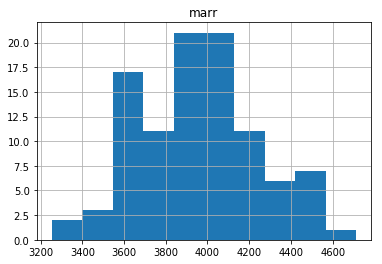

In [146]:
from sklearn.ensemble import RandomForestRegressor

outcomes = ["nifa"]
treatments = ["marr"]

estimates = DoubleML()\
.set_model(RandomForestRegressor(max_depth=2))\
.set_df(df)\
.set_outcomes(outcomes)\
.set_treatments(treatments)\
.estimate(100)

print(estimates.describe())

import matplotlib.pyplot as plt
%matplotlib inline

estimates.hist(bins=10)